In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pickle

In [2]:
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [3]:
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

C:\Users\bwils\anaconda3\envs\micromotion\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54282 instead
  warnings.warn(


(<Scheduler: "tcp://127.0.0.1:54287" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:54309, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:54310, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:54306, threads: 2>})

In [4]:
train_X = pd.read_pickle('DFs/train_test/train_X.pkl')
train_y = pd.read_pickle('DFs/train_test/train_y.pkl')
test_X = pd.read_pickle('DFs/train_test/test_X.pkl')
test_y = pd.read_pickle('DFs/train_test/test_y.pkl')

In [5]:
f = open(r'DFs/train_test/participants.pkl', 'rb')
participants = pickle.load(f)
f.close()

In [6]:
from model_prep import score_model

In [7]:
from model_prep import plot_predictions

# SGD Regressor Loss=Huber
SGD Regressor when run with Huber loss is a linear model. Let's see if it works as well as ElasticNet.

In [8]:
#create and fit model
sgd = SGDRegressor(loss='huber')
pca50 = PCA(n_components=50)
train_X_pca50 = pca50.fit_transform(train_X)
test_X_pca50 = pca50.transform(test_X)
sgd.fit(train_X_pca50, train_y) 

SGDRegressor(loss='huber')

In [9]:
#create logging dictionary
sgd_scores = {'model':[],'par':[],'MAPE':[], 'MAE':[]}
for param in sgd.get_params():
    sgd_scores[param]=[]

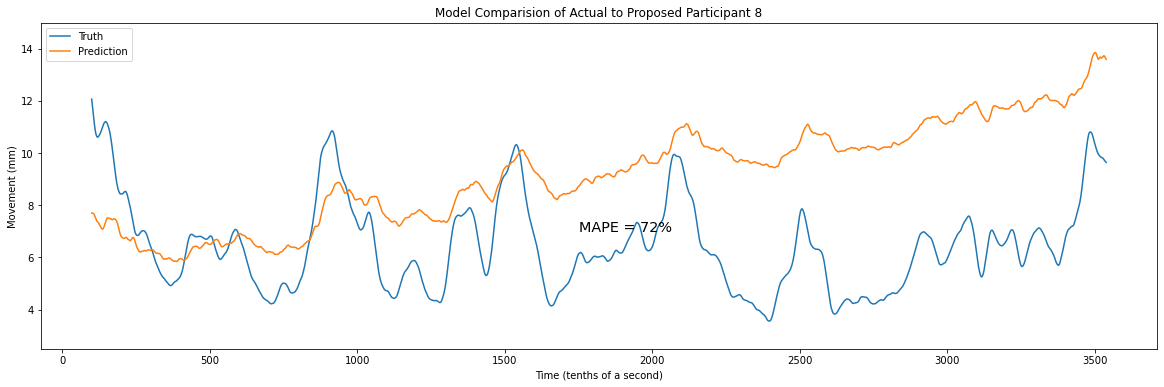

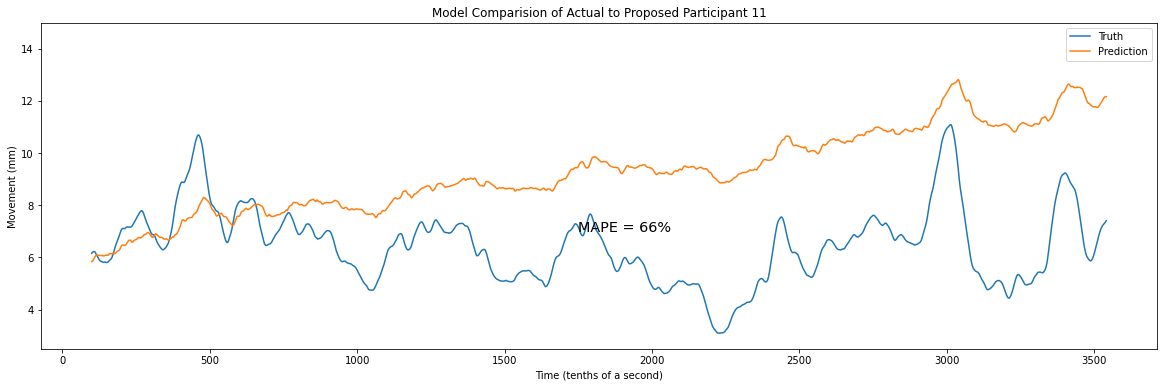

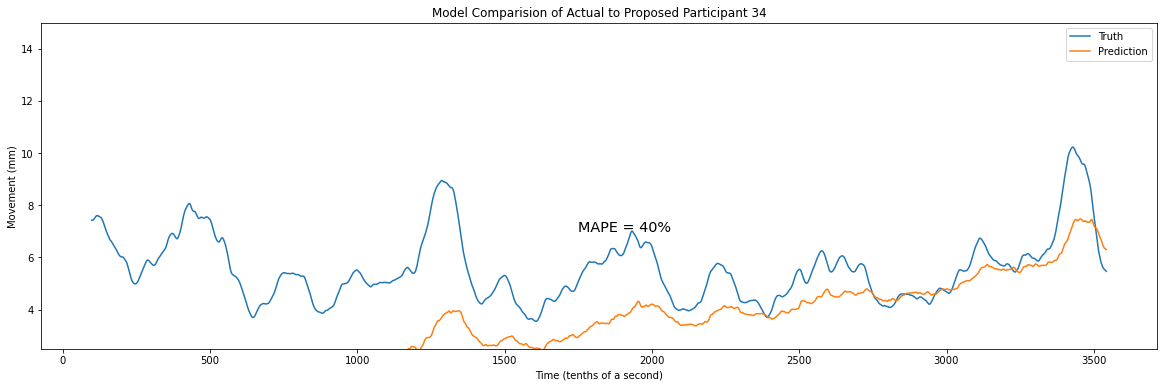

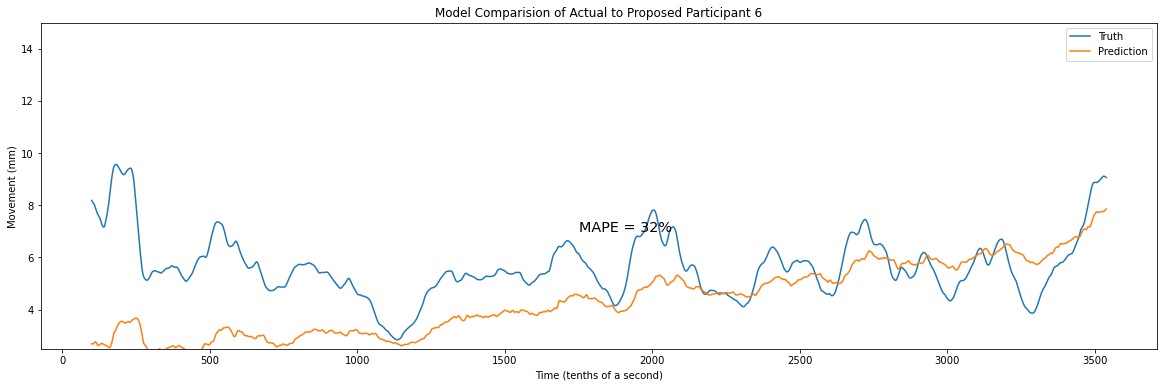

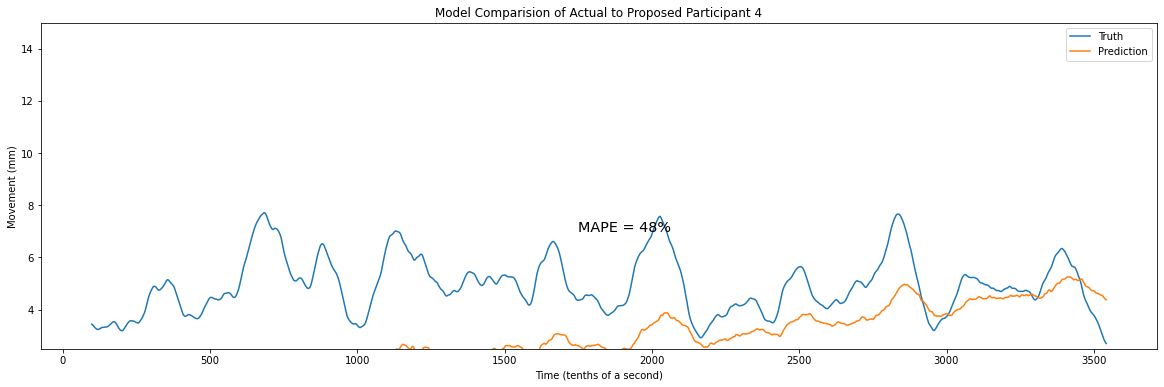

In [10]:
#Visualize predictions and truths
results, sgd_scores = score_model(sgd, participants=participants, test_y=test_y, test_X=test_X_pca50, 
                      model_name='SGD_huber', log = sgd_scores)
plot_predictions(results, participants)

Not as good as the ElasticNet, but it does seem to follow a similar trend to the truth data. The predictions drift either too high or too low as time goies on, let'see if we can adjust that with the epsilon parameter, which creates better control over outliers.

The default value is 0.1, we'll next try 0.5.

In [11]:
#create and fit model
sgd05 = SGDRegressor(loss='huber', epsilon=0.5)
pca50 = PCA(n_components=50)
train_X_pca50 = pca50.fit_transform(train_X)
test_X_pca50 = pca50.transform(test_X)
sgd05.fit(train_X_pca50, train_y) 

SGDRegressor(epsilon=0.5, loss='huber')

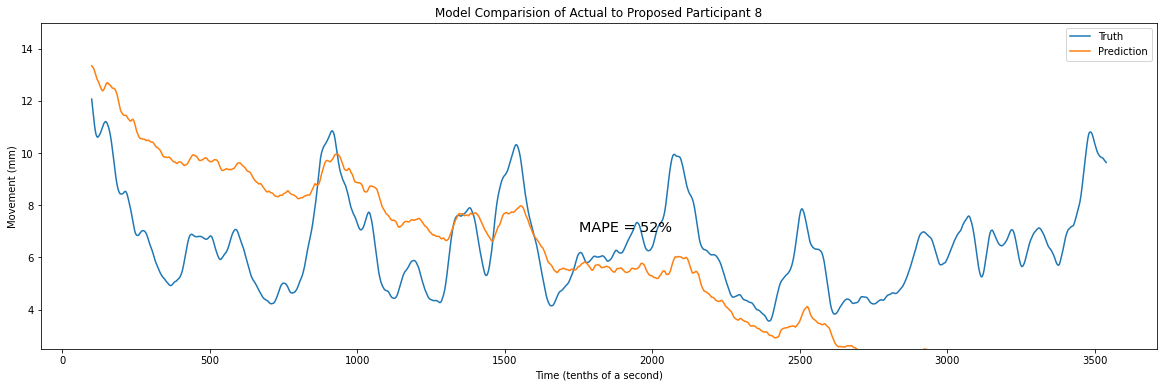

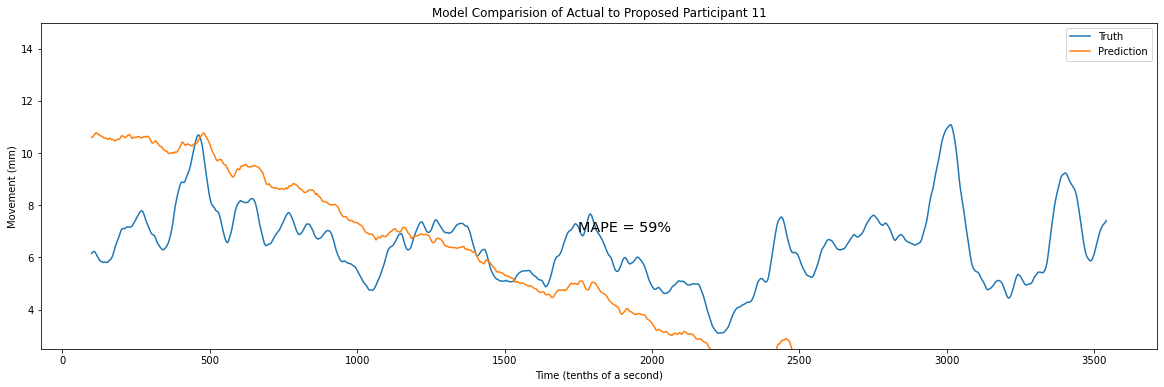

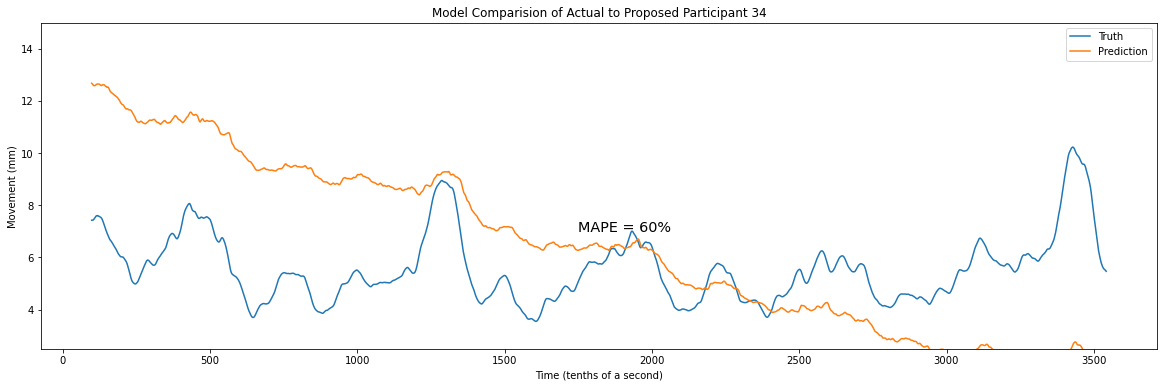

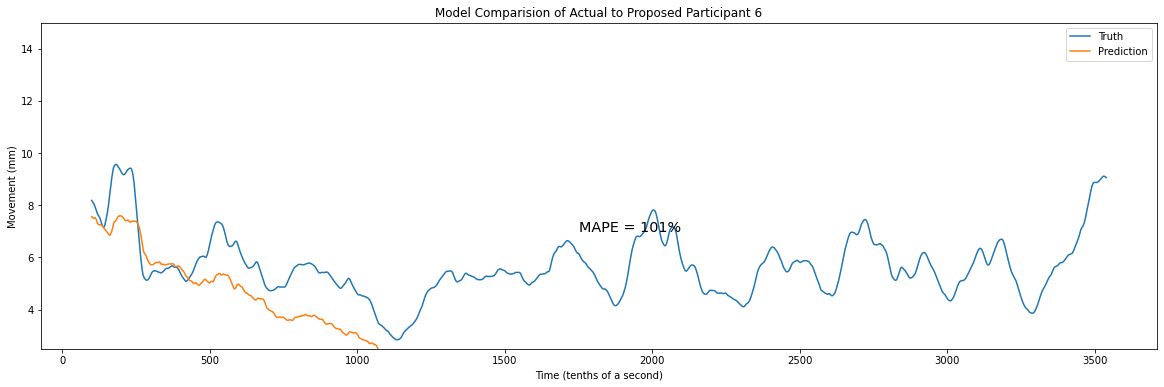

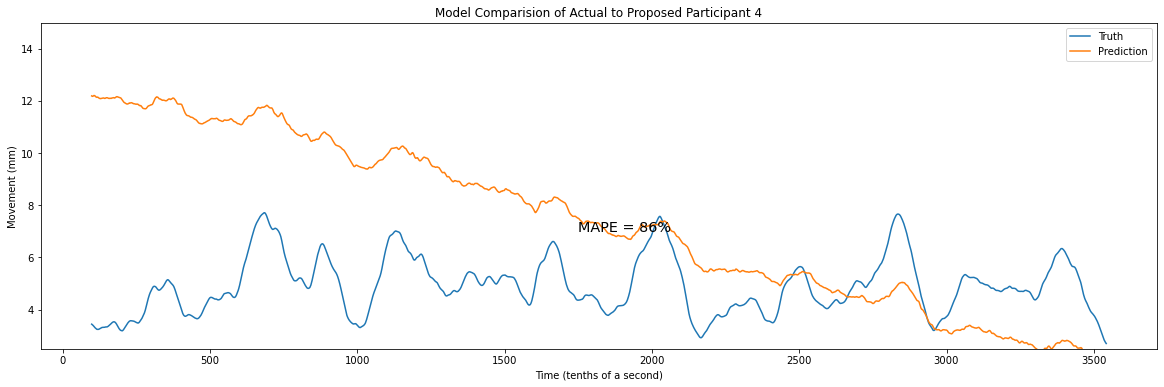

In [12]:
#Visualize predictions and truths
results, sgd_scores = score_model(sgd05, participants=participants, test_y=test_y, test_X=test_X_pca50, 
                      model_name='SGD_huber0.5', log = sgd_scores)
plot_predictions(results, participants)

Considerably greater error in these predictions. Let's bring epsilon down to 0.25.

In [13]:
#create and fit model
sgd025 = SGDRegressor(loss='huber', epsilon=0.25)
pca50 = PCA(n_components=50)
train_X_pca50 = pca50.fit_transform(train_X)
test_X_pca50 = pca50.transform(test_X)
sgd025.fit(train_X_pca50, train_y) 

SGDRegressor(epsilon=0.25, loss='huber')

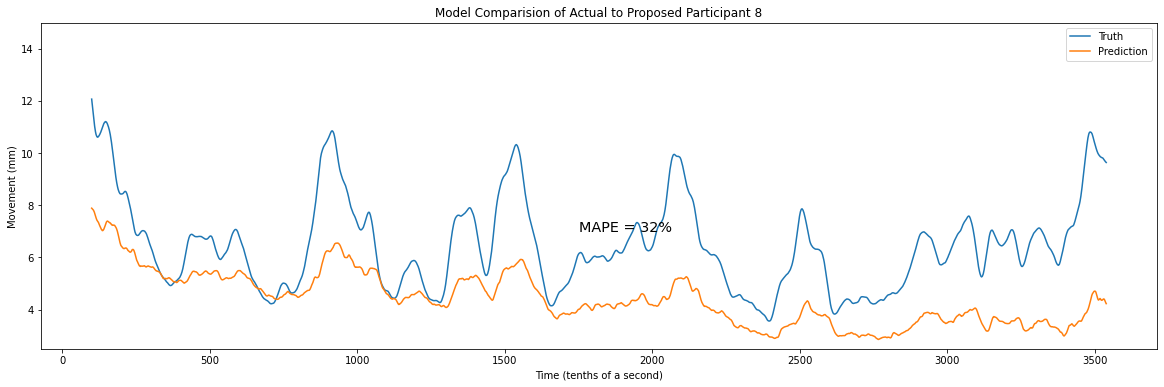

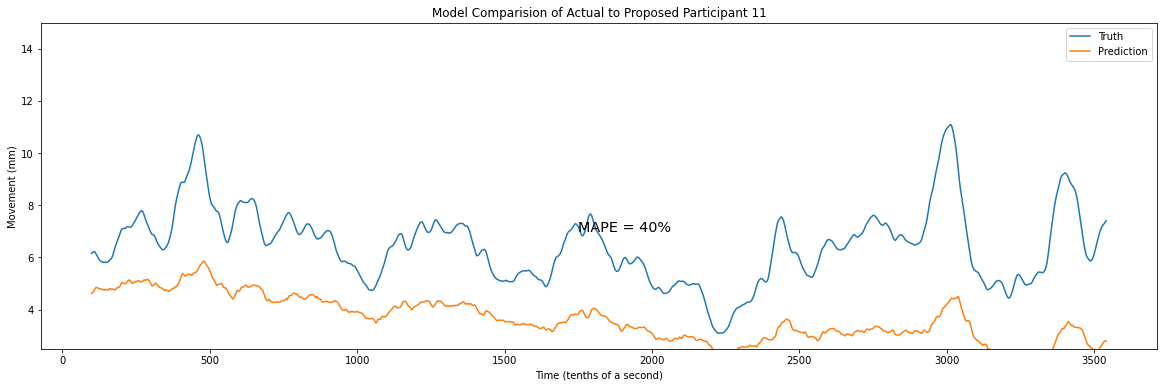

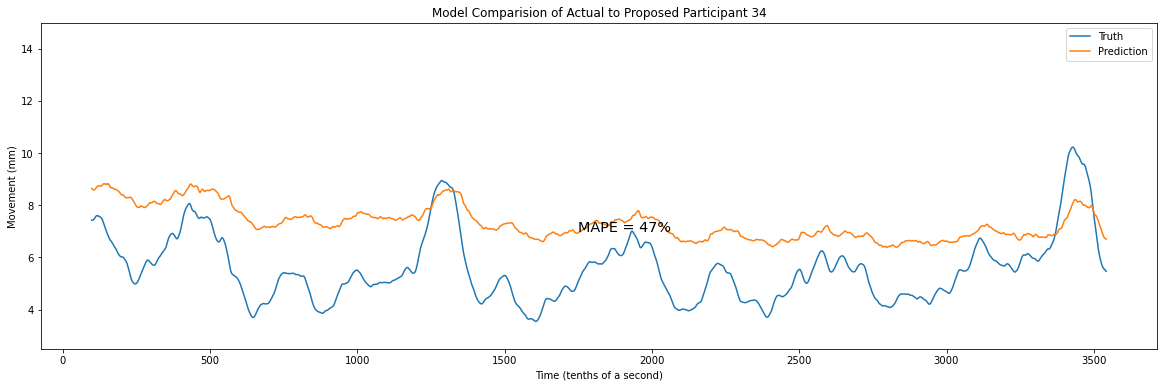

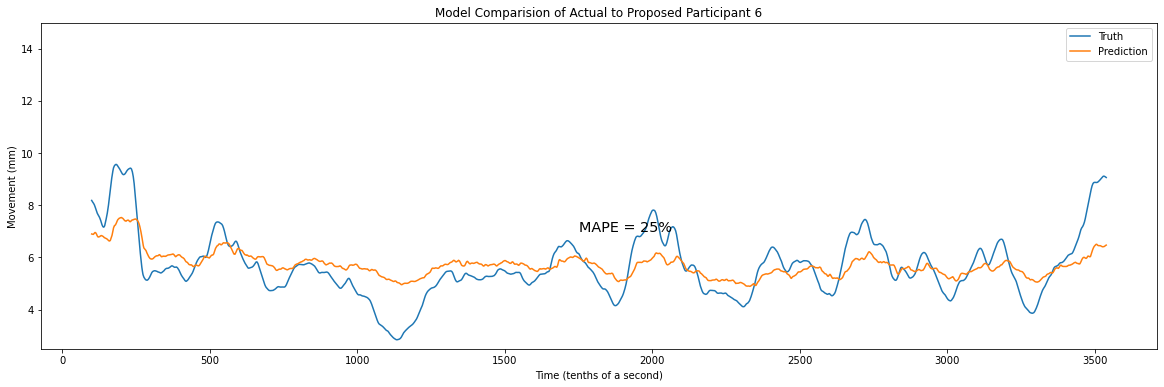

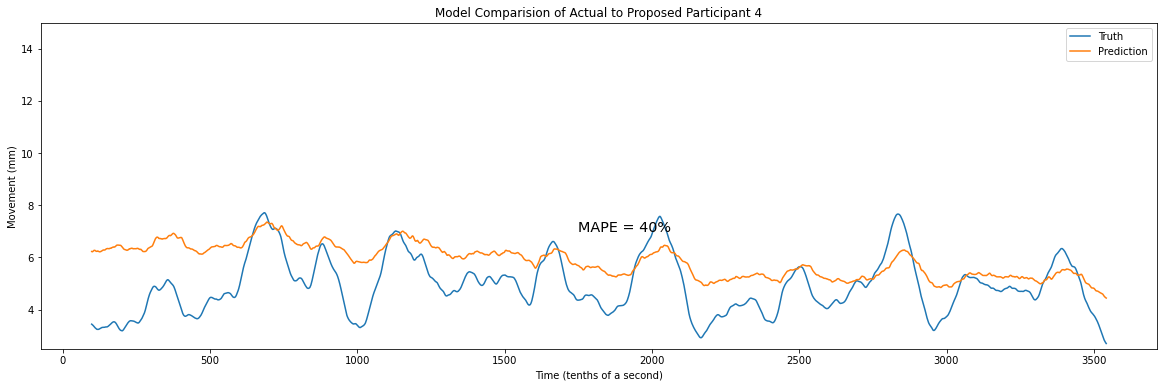

In [14]:
#Visualize predictions and truths
results, sgd_scores = score_model(sgd025, participants=participants, test_y=test_y, test_X=test_X_pca50, 
                      model_name='SGD_huber0.25', log = sgd_scores)
plot_predictions(results, participants)

Pretty good except for participant #6 whose error keeps increasing off screen. Why don't we try a value lower than the default 0.1, 0.01

In [15]:
#create and fit model
sgd001 = SGDRegressor(loss='huber', epsilon=0.01)
pca50 = PCA(n_components=50)
train_X_pca50 = pca50.fit_transform(train_X)
test_X_pca50 = pca50.transform(test_X)
sgd001.fit(train_X_pca50, train_y) 

SGDRegressor(epsilon=0.01, loss='huber')

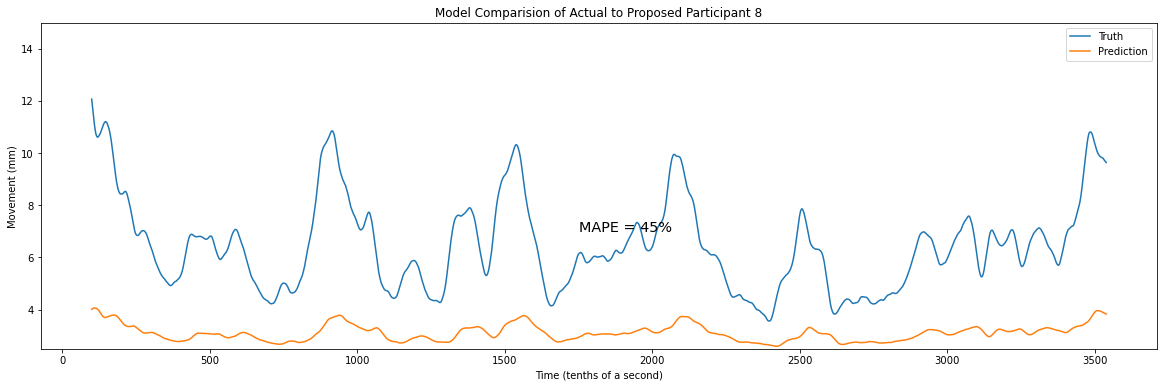

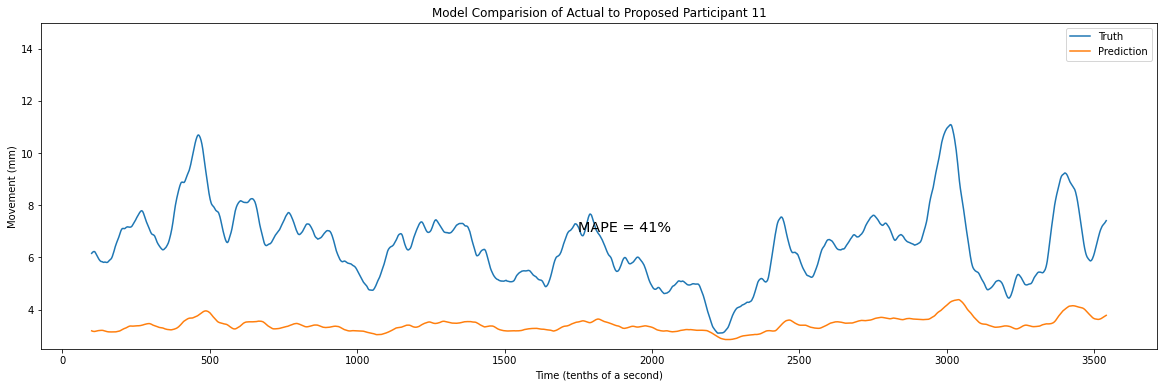

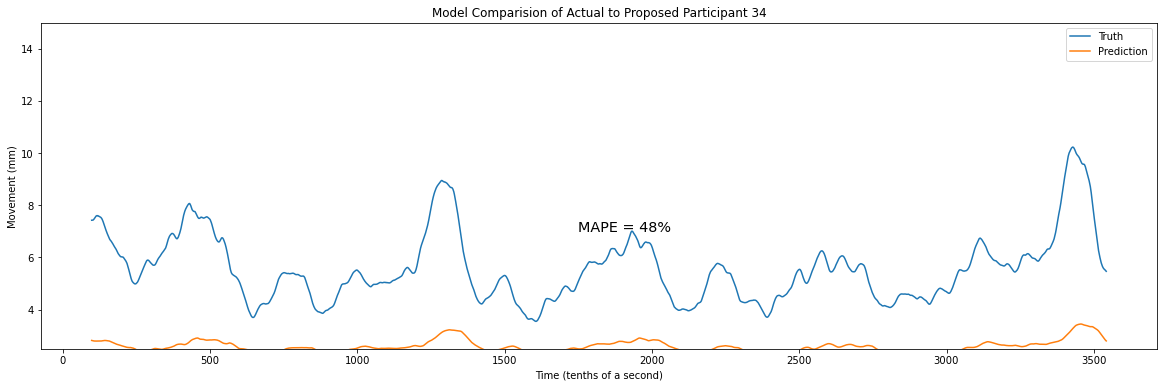

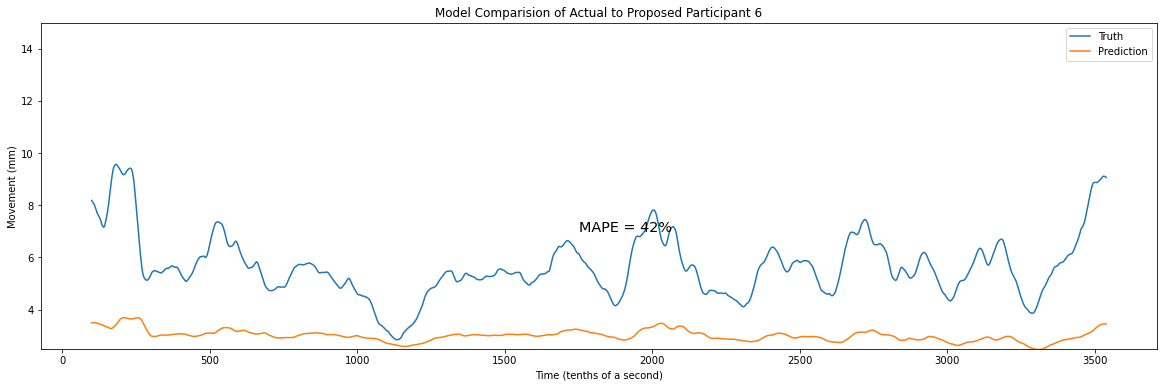

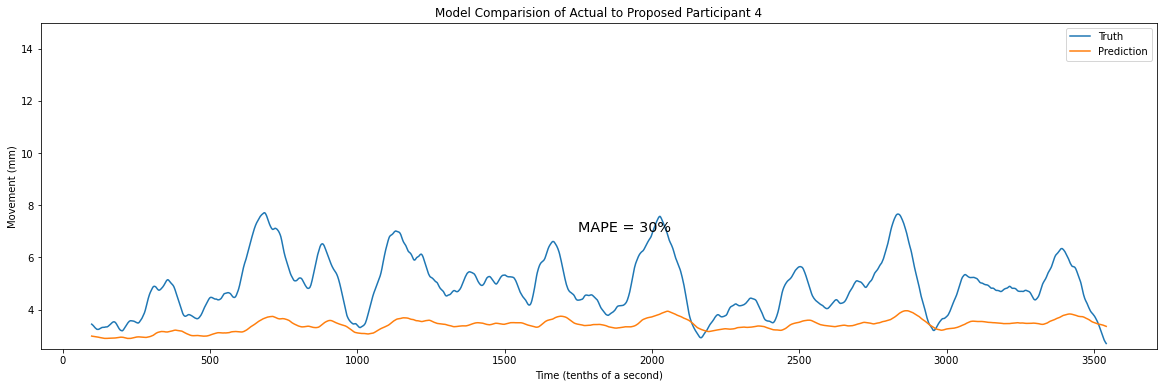

In [16]:
#Visualize predictions and truths
results, sgd_scores = score_model(sgd001, participants=participants, test_y=test_y, test_X=test_X_pca50, 
                      model_name='SGD_huber0.01', log = sgd_scores)
plot_predictions(results, participants)

The 0.01 epsilon value cuased our predictions to become more consistent, but lose some of the ability to follow the amplitude. Let's stay below the default but raise up to 0.05.

In [17]:
#create and fit model
sgd005 = SGDRegressor(loss='huber', epsilon=0.05)
pca50 = PCA(n_components=50)
train_X_pca50 = pca50.fit_transform(train_X)
test_X_pca50 = pca50.transform(test_X)
sgd005.fit(train_X_pca50, train_y) 

SGDRegressor(epsilon=0.05, loss='huber')

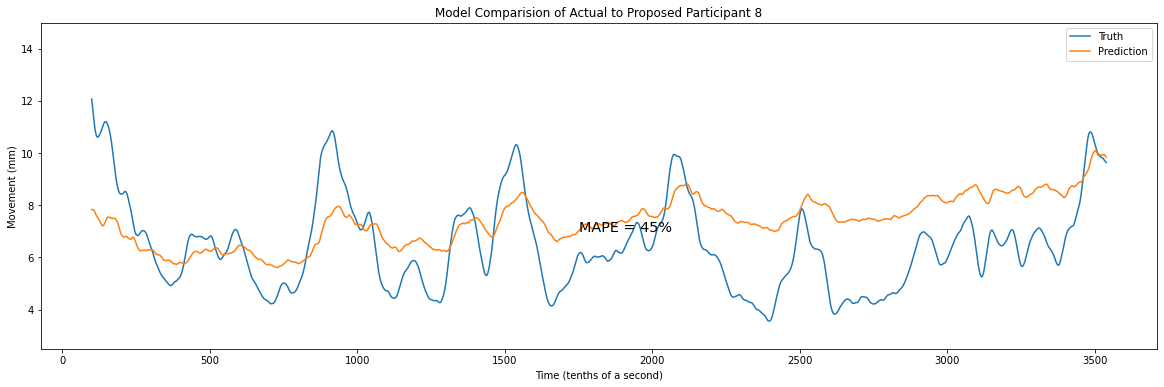

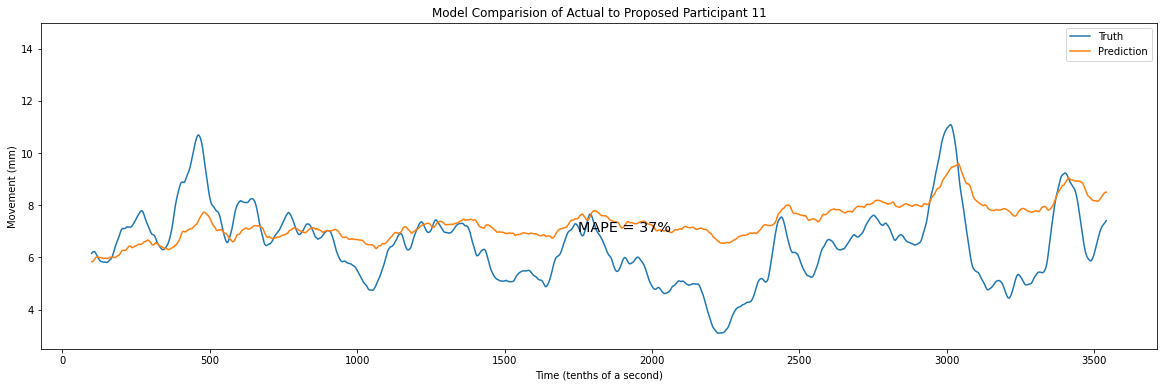

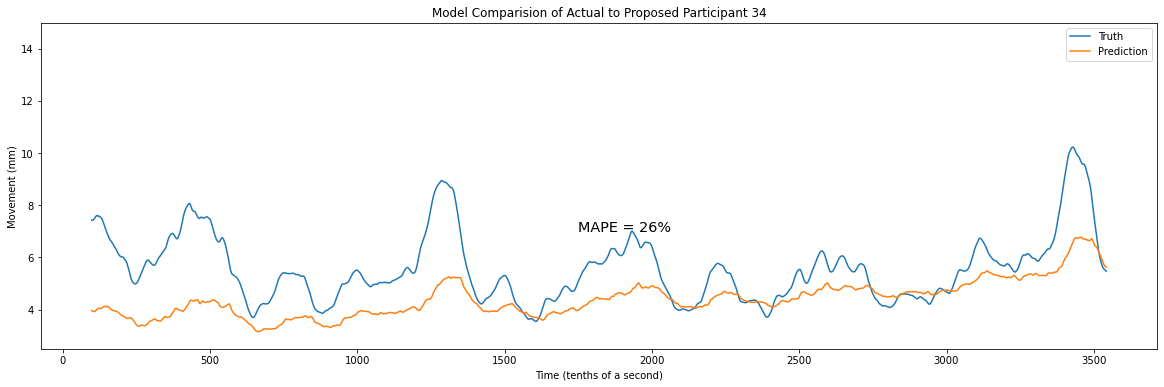

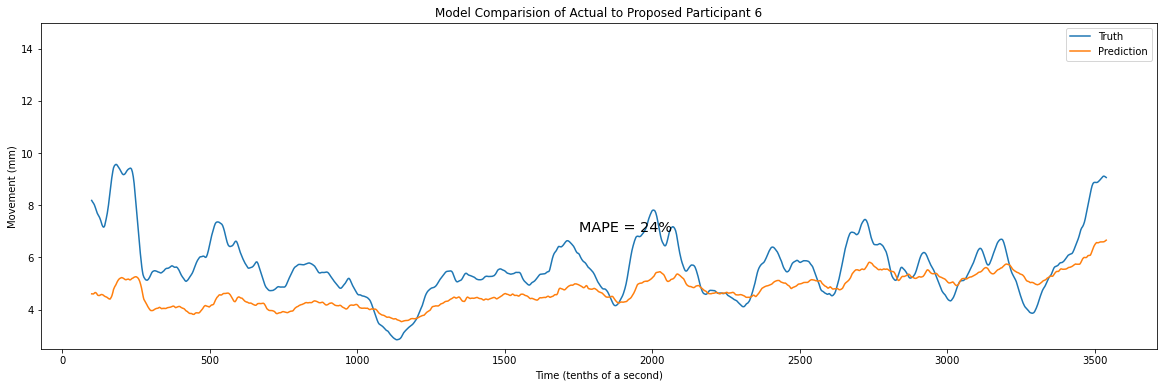

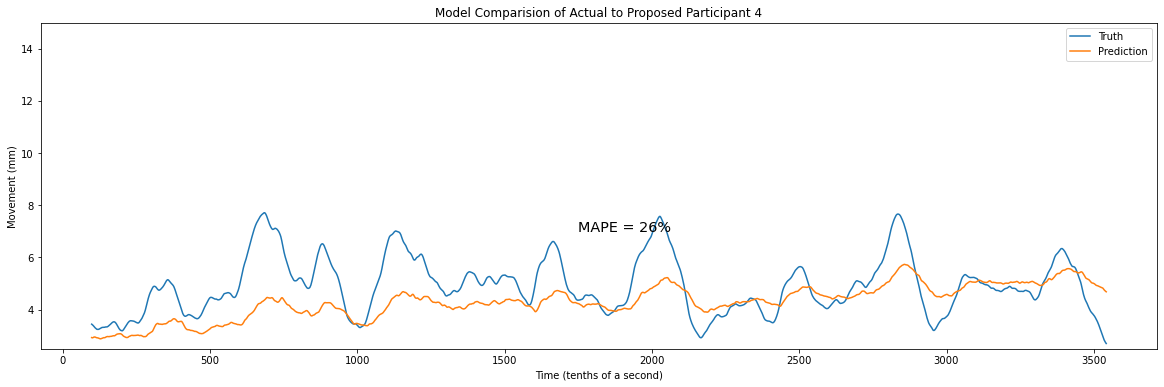

In [18]:
#Visualize predictions and truths
results, sgd_scores = score_model(sgd005, participants=participants, test_y=test_y, test_X=test_X_pca50, 
                      model_name='SGD_huber0.05', log = sgd_scores)
plot_predictions(results, participants)

The best so far. The linear models seem to do a good job of finding the trend. An importnant improvement for the future would be in increasing their ability to determine the correct magnitude.

In [19]:
sgd_scores.keys()

dict_keys(['model', 'par', 'MAPE', 'MAE', 'alpha', 'average', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [20]:
#convert metrics dictionary to dataframe
sgd_df = pd.DataFrame(sgd_scores)

In [21]:
#view model metrics by particpant
sgd_df.groupby(['par','model']).mean()

MAPE       MAE   alpha  average  early_stopping  \
par model                                                                
4   SGD_huber      0.483040  2.406792  0.0001    False           False   
    SGD_huber0.01  0.301835  1.671186  0.0001    False           False   
    SGD_huber0.05  0.268708  1.300813  0.0001    False           False   
    SGD_huber0.25  0.405221  1.550948  0.0001    False           False   
    SGD_huber0.5   0.868177  3.507725  0.0001    False           False   
6   SGD_huber      0.328837  1.938900  0.0001    False           False   
    SGD_huber0.01  0.427464  2.722527  0.0001    False           False   
    SGD_huber0.05  0.246767  1.495603  0.0001    False           False   
    SGD_huber0.25  0.251616  1.323160  0.0001    False           False   
    SGD_huber0.5   1.019683  5.684097  0.0001    False           False   
8   SGD_huber      0.728361  3.585453  0.0001    False           False   
    SGD_huber0.01  0.458947  3.473094  0.0001    False           False   
    SGD_huber0.05  0.455997  2.356318  0.0001    False           False   
    SGD_huber0.25  0.325519  2.397465  0.0001    False           False   
    SGD_huber0.5   0.526152  3.152956  0.0001    False           False   
11  SGD_huber      0.663188  3.357254  0.0001    False           False   
    SGD_huber0.01  0.419991  3.083497  0.0001    False           False   
    SGD_huber0.05  0.376883  1.958898  0.0001    False           False   
    SGD_huber0.25  0.405211  2.870372  0.0001    False           False   
    SGD_huber0.5   0.590798  3.729261  0.0001    False           False   
34  SGD_huber      0.407417  2.432293  0.0001    False           False   
    SGD_huber0.01  0.489445  2.999092  0.0001    False           False   
    SGD_huber0.05  0.261265  1.610285  0.0001    False           False   
    SGD_huber0.25  0.476920  2.125807  0.0001    False           False   
    SGD_huber0.5   0.606230  3.079222  0.0001    False           False   

                   epsilon  eta0  fit_intercept  l1_ratio  max_iter  \
par model                                                             
4   SGD_huber         0.10  0.01           True      0.15      1000   
    SGD_huber0.01     0.01  0.01           True      0.15      1000   
    SGD_huber0.05     0.05  0.01           True      0.15      1000   
    SGD_huber0.25     0.25  0.01           True      0.15      1000   
    SGD_huber0.5      0.50  0.01           True      0.15      1000   
6   SGD_huber         0.10  0.01           True      0.15      1000   
    SGD_huber0.01     0.01  0.01           True      0.15      1000   
    SGD_huber0.05     0.05  0.01           True      0.15      1000   
    SGD_huber0.25     0.25  0.01           True      0.15      1000   
    SGD_huber0.5      0.50  0.01           True      0.15      1000   
8   SGD_huber         0.10  0.01           True      0.15      1000   
    SGD_huber0.01     0.01  0.01           True      0.15      1000   
    SGD_huber0.05     0.05  0.01           True      0.15      1000   
    SGD_huber0.25     0.25  0.01           True      0.15      1000   
    SGD_huber0.5      0.50  0.01           True      0.15      1000   
11  SGD_huber         0.10  0.01           True      0.15      1000   
    SGD_huber0.01     0.01  0.01           True      0.15      1000   
    SGD_huber0.05     0.05  0.01           True      0.15      1000   
    SGD_huber0.25     0.25  0.01           True      0.15      1000   
    SGD_huber0.5      0.50  0.01           True      0.15      1000   
34  SGD_huber         0.10  0.01           True      0.15      1000   
    SGD_huber0.01     0.01  0.01           True      0.15      1000   
    SGD_huber0.05     0.05  0.01           True      0.15      1000   
    SGD_huber0.25     0.25  0.01           True      0.15      1000   
    SGD_huber0.5      0.50  0.01           True      0.15      1000   

                   n_iter_no_change  power_t  shuffle    tol  \
par model                                 

In [22]:
#view model metrics and parameters
sgd_df.groupby(['model']).mean()

,par,MAPE,MAE,alpha,average,early_stopping,epsilon,eta0,fit_intercept,l1_ratio,max_iter,n_iter_no_change,power_t,shuffle,tol,validation_fraction,verbose,warm_start
model,,,,,,,,,,,,,,,,,,
SGD_huber,12.6,0.522169,2.744138,0.0001,False,False,0.10,0.01,True,0.15,1000.0,5.0,0.25,True,0.001,0.1,0.0,False
SGD_huber0.01,12.6,0.419537,2.789879,0.0001,False,False,0.01,0.01,True,0.15,1000.0,5.0,0.25,True,0.001,0.1,0.0,False
SGD_huber0.05,12.6,0.321924,1.744384,0.0001,False,False,0.05,0.01,True,0.15,1000.0,5.0,0.25,True,0.001,0.1,0.0,False
SGD_huber0.25,12.6,0.372897,2.053551,0.0001,False,False,0.25,0.01,True,0.15,1000.0,5.0,0.25,True,0.001,0.1,0.0,False
SGD_huber0.5,12.6,0.722208,3.830652,0.0001,False,False,0.50,0.01,True,0.15,1000.0,5.0,0.25,True,0.001,0.1,0.0,False


In [23]:
#output for comparison
sgd_df.to_pickle(r'DFs/scores/sgd.pkl')